In [187]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sin, cos, radians
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.linear_model import LinearRegression
sns.set()

In [188]:
df_data_1996 = pd.read_csv(f'../Data/BHPtrainingLongProcessed.zip', index_col = 'Date Time', parse_dates=True)
df_data_2016 = pd.read_csv(f'../Data/BHPtraining.csv', index_col = 'Date Time', parse_dates = True)
df_data_2020 = pd.read_csv(f'../Data/BHPtest.csv', index_col = 'Date Time', parse_dates = True)
predictions_df = pd.read_csv(f'../Data/BHPPredictions.zip', index_col = 'Date Time', parse_dates = True)
predictions_df = predictions_df.rename(columns={predictions_df.columns[0]: 'pTide'})

In [189]:
def raw_dataset():
    df_raw = pd.concat([df_data_1996, df_data_2016, df_data_2020])
    df_raw = pd.merge(df_raw, predictions_df, left_index=True, right_index=True)
    return df_raw

In [190]:
def preprocess(dataframe):
    # Drop minute data
    df = dataframe[dataframe.index.minute == 0].copy()
    # Calculate across and along shore winds, offset of 30 degrees
    df['uWind'] = df['Wind Speed'].multiply(np.cos(np.radians(df['Wind Direction']-30)))
    df['vWind'] = df['Wind Speed'].multiply(np.sin(np.radians(df['Wind Direction']-30)))
    # Create Season feature
    df['season'] = np.where(df.index.month.isin([12, 1, 2]), 'winter',
                                np.where(df.index.month.isin([3, 4, 5]), 'spring',
                                         np.where(df.index.month.isin([6, 7, 8]), 'summer', 'fall')))
    # Create dummy variables for Season, to be used in regression model
    df = pd.get_dummies(df, columns=['season'], drop_first=True)
    #Remove significant outliers in Water Level
    df = df[np.abs(df['Air Temperature'] - df['Air Temperature'].mean()) <= (3 * df['Air Temperature'].std())]
    # Interpolate Missing Data: 3 hour limit for winds, 12 hour limit for Water Level, Surge, and Water Level Sigma
    df[['uWind', 'vWind', 'Wind Speed', 'Wind Gust', 'Air Temperature']] = df[['uWind', 'vWind', 'Wind Speed', 'Wind Gust', 'Air Temperature']].interpolate(method='linear', limit=6)
    # Drop remaining missing values
    df = df.dropna()

    return df

In [191]:
df_raw = raw_dataset()
df_clean = preprocess(df_raw)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120925 entries, 2001-10-28 00:00:00 to 2020-10-21 01:00:00
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Air Temperature    120925 non-null  float64
 1   Water Level        120925 non-null  float64
 2   Water Level Sigma  120925 non-null  float64
 3   Wind Speed         120925 non-null  float64
 4   Wind Direction     120925 non-null  float64
 5   Wind Gust          120925 non-null  float64
 6   pTide              120925 non-null  float64
 7   uWind              120925 non-null  float64
 8   vWind              120925 non-null  float64
 9   season_spring      120925 non-null  bool   
 10  season_summer      120925 non-null  bool   
 11  season_winter      120925 non-null  bool   
dtypes: bool(3), float64(9)
memory usage: 9.6 MB


In [192]:
df_clean

,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Direction,Wind Gust,pTide,uWind,vWind,season_spring,season_summer,season_winter
Date Time,,,,,,,,,,,,
2001-10-28 00:00:00,55.8,1.437,0.056,0.00,87.0,0.00,1.005,0.000000,0.000000,False,False,False
2001-10-28 01:00:00,55.4,1.424,0.056,0.00,81.0,0.00,1.043,0.000000,0.000000,False,False,False
2001-10-28 02:00:00,54.5,1.496,0.072,0.00,98.0,0.00,1.153,0.000000,0.000000,False,False,False
2001-10-28 03:00:00,53.4,1.699,0.085,0.00,100.0,0.00,1.331,0.000000,0.000000,False,False,False
2001-10-28 04:00:00,52.3,1.804,0.052,0.00,108.0,0.00,1.537,0.000000,0.000000,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-20 21:00:00,81.7,1.706,0.322,11.86,67.0,13.02,1.180,9.471817,7.137526,False,False,False
2020-10-20 22:00:00,80.2,2.100,0.397,12.05,73.0,14.00,1.619,8.812812,8.218080,False,False,False
2020-10-20 23:00:00,79.7,2.589,0.381,13.02,76.0,14.58,1.997,9.044452,9.365804,False,False,False


In [193]:
df_clean.corr()

,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Direction,Wind Gust,pTide,uWind,vWind,season_spring,season_summer,season_winter
Air Temperature,1.000000,0.203079,0.122164,0.059981,-0.177762,0.026749,0.227507,-0.371277,0.551108,-0.061560,0.536696,-0.680166
Water Level,0.203079,1.000000,0.225803,0.036717,-0.031725,0.043175,0.809420,0.102203,0.002261,-0.031013,-0.084761,-0.203267
Water Level Sigma,0.122164,0.225803,1.000000,0.149535,0.004613,0.155768,0.084331,0.037639,0.031211,-0.158152,0.045766,-0.081411
Wind Speed,0.059981,0.036717,0.149535,1.000000,-0.039194,0.983185,-0.016090,0.036791,0.265634,0.112159,0.011065,-0.098998
Wind Direction,-0.177762,-0.031725,0.004613,-0.039194,1.000000,0.010580,-0.001888,-0.231483,-0.380540,-0.058241,-0.017744,0.061342
Wind Gust,0.026749,0.043175,0.155768,0.983185,0.010580,1.000000,-0.010765,0.067246,0.185341,0.113417,-0.008654,-0.091888
pTide,0.227507,0.809420,0.084331,-0.016090,-0.001888,-0.010765,1.000000,-0.033387,0.024769,-0.005494,-0.079712,-0.300127
uWind,-0.371277,0.102203,0.037639,0.036791,-0.231483,0.067246,-0.033387,1.000000,-0.522752,-0.009357,-0.260651,0.180368
vWind,0.551108,0.002261,0.031211,0.265634,-0.380540,0.185341,0.024769,-0.522752,1.000000,0.144881,0.248054,-0.307996
season_spring,-0.061560,-0.031013,-0.158152,0.112159,-0.058241,0.113417,-0.005494,-0.009357,0.144881,1.000000,-0.320673,-0.325110


In [194]:
def data_split(dataframe):
    train = dataframe[((dataframe.index.year >= 1996) & (dataframe.index.year <= 2018))]
    validate = dataframe[dataframe.index.year == 2019]
    test = dataframe[dataframe.index.year == 2020]

    return train, validate, test

In [195]:
def data_sample(df, features, leadtime_hours=24):
  data = []
  labels = []

  for index, row in df.iterrows():

    if index.hour == 0 or index.hour == 12:
        # Start and End time for 24 hours prior to observation
        end_datetime = index - pd.Timedelta(hours = 24)
        start_datetime = end_datetime - pd.Timedelta(hours = leadtime_hours)

        # Slice the DataFrame into 24 hour windows
        window = df.loc[start_datetime:end_datetime]
        # If we do not have 24 hours of continuous data, throw out interval
        if window.shape != (leadtime_hours + 1, df.shape[1]):
            continue
    
        # Extract the ith observation for our label value
        label = None
        try:
            label = df.loc[index]['Air Temperature']
        except KeyError:
            continue

        # Transform each feature into a array containing 24 hours worth of values of that feature
        input_vector = []
        for feature in features:
            input_vector = input_vector + window[feature].tolist()

        data.append(input_vector)
        labels.append(label)

  return data, labels

In [196]:
def evaluate(predictions, labels, predictions_best):
    mse = mean_squared_error(predictions, labels)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(predictions, labels)
    median_ae = median_absolute_error(predictions, labels)
    mean_error = np.mean(predictions - labels)
    r2 = r2_score(predictions, labels)
    cf = central_frequency(predictions, labels)

    print("\nCentral Frequency:", cf)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Average Error:", mean_error)
    print("Mean Absolute Error:", mae)
    print("Median Absolute Error:", median_ae)
    print("Mean Error:", mean_error)
    print("R-squared:", r2)

    mse_best = mean_squared_error(predictions_best, labels)
    r2_best = r2_score(predictions_best, labels)
    cf_best = central_frequency(predictions_best, labels)

    print('-------------------')
    print('Difference from Current Best Model')
    print('-------------------')
    print('Central Frequency Difference: {:.6f}'.format(cf_best-cf))
    print('Mean Square Error Difference:{:.6f}'.format(mse_best-mse))
    print('R-squared Difference:{:.6f}'.format(r2_best-r2))
    print('')
def central_frequency(predictions, labels):
    temp = 0

    for i in range(0, len(predictions)):
        if abs(predictions[i] - labels[i]) <= 5:
            temp = temp + 1
    return temp / len(predictions)

In [197]:
def evaluate_final(predictions, labels):
    mse = mean_squared_error(predictions, labels)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(predictions, labels)
    median_ae = median_absolute_error(predictions, labels)
    mean_error = np.mean(predictions - labels)
    r2 = r2_score(predictions, labels)
    cf = central_frequency(predictions, labels)

    print("\nCentral Frequency:", cf)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Average Error:", mean_error)
    print("Mean Absolute Error:", mae)
    print("Median Absolute Error:", median_ae)
    print("Mean Error:", mean_error)
    print("R-squared:", r2)
    
def central_frequency(predictions, labels):
    temp = 0

    for i in range(0, len(predictions)):
        if abs(predictions[i] - labels[i]) <= 5:
            temp = temp + 1
    return temp / len(predictions)

In [198]:
def model_plot(predictions, labels):
    plt.figure(figsize=(25,10))
    plt.plot(labels, label='Targets')
    plt.plot(predictions, label='Predictions')
    plt.title('Predictions vs Targets', size=22)
    plt.xlabel('Observation (24hr Lag)', size=22)
    plt.ylabel('Water Level', size=22)
    plt.legend()
    plt.show()

In [199]:
df_train, df_validate, df_test = data_split(df_clean)

In [200]:
training_data, training_labels = data_sample(df_train, ['Air Temperature',  'vWind', 'uWind', 'Wind Speed', 'Wind Gust','season_summer', 'season_spring', 'season_winter'])
validation_data, validation_labels = data_sample(df_validate, ['Air Temperature',  'vWind', 'Wind Speed', 'Wind Gust','uWind', 'season_summer', 'season_spring', 'season_winter'])
testing_data, testing_labels = data_sample(df_test, ['Air Temperature',  'vWind', 'uWind', 'Wind Speed', 'Wind Gust','season_summer', 'season_spring', 'season_winter'])

In [201]:
model = LinearRegression()
model.fit(training_data, training_labels)

LinearRegression()

In [202]:
predictions = model.predict(training_data)

In [203]:
evaluate_final(predictions, training_labels)


Central Frequency: 0.86496
Mean Squared Error: 16.21308796919894
Root Mean Squared Error: 4.026547897293529
Average Error: -2.897195372497663e-14
Mean Absolute Error: 2.5761023762866087
Median Absolute Error: 1.587461884548837
Mean Error: -2.897195372497663e-14
R-squared: 0.8253966031422594


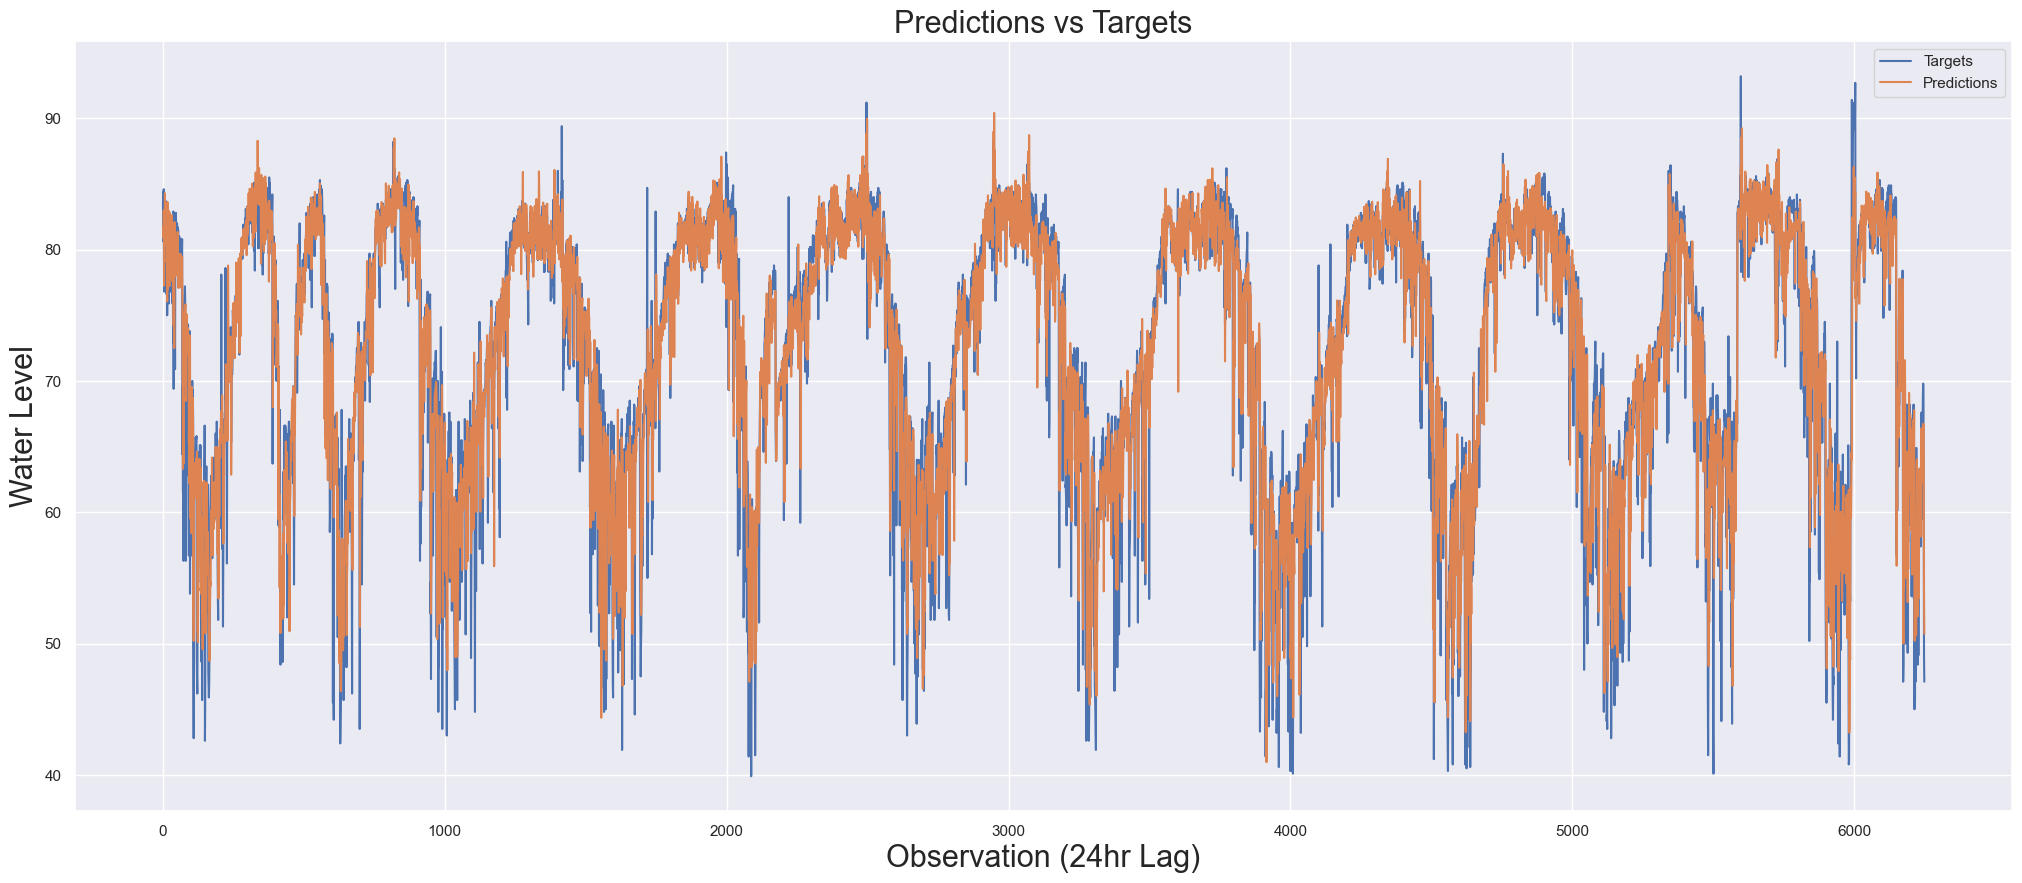

In [204]:
model_plot(predictions, training_labels)

In [205]:
training_data, training_labels = data_sample(df_train, ['Air Temperature',  'vWind', 'uWind', 'Wind Speed', 'Wind Gust', 'season_summer', 'season_spring', 'season_winter'])
validation_data, validation_labels = data_sample(df_validate, ['Air Temperature',  'vWind',  'uWind', 'Wind Speed', 'Wind Gust', 'season_summer', 'season_spring', 'season_winter'])
testing_data, testing_labels = data_sample(df_test, ['Air Temperature',  'vWind', 'uWind', 'Wind Speed', 'Wind Gust', 'season_summer', 'season_spring', 'season_winter'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(training_data)
evaluate_final(predictions, training_labels)



Central Frequency: 0.86496
Mean Squared Error: 16.21308796919894
Root Mean Squared Error: 4.026547897293529
Average Error: -2.897195372497663e-14
Mean Absolute Error: 2.5761023762866087
Median Absolute Error: 1.587461884548837
Mean Error: -2.897195372497663e-14
R-squared: 0.8253966031422594


In [206]:
predictions = model.predict(validation_data)
evaluate_final(predictions, validation_labels)


Central Frequency: 0.8268551236749117
Mean Squared Error: 24.571305548209452
Root Mean Squared Error: 4.9569451830950735
Average Error: 0.5125479733121734
Mean Absolute Error: 3.0061239305497662
Median Absolute Error: 1.7758518106732026
Mean Error: 0.5125479733121734
R-squared: 0.8019616395107363


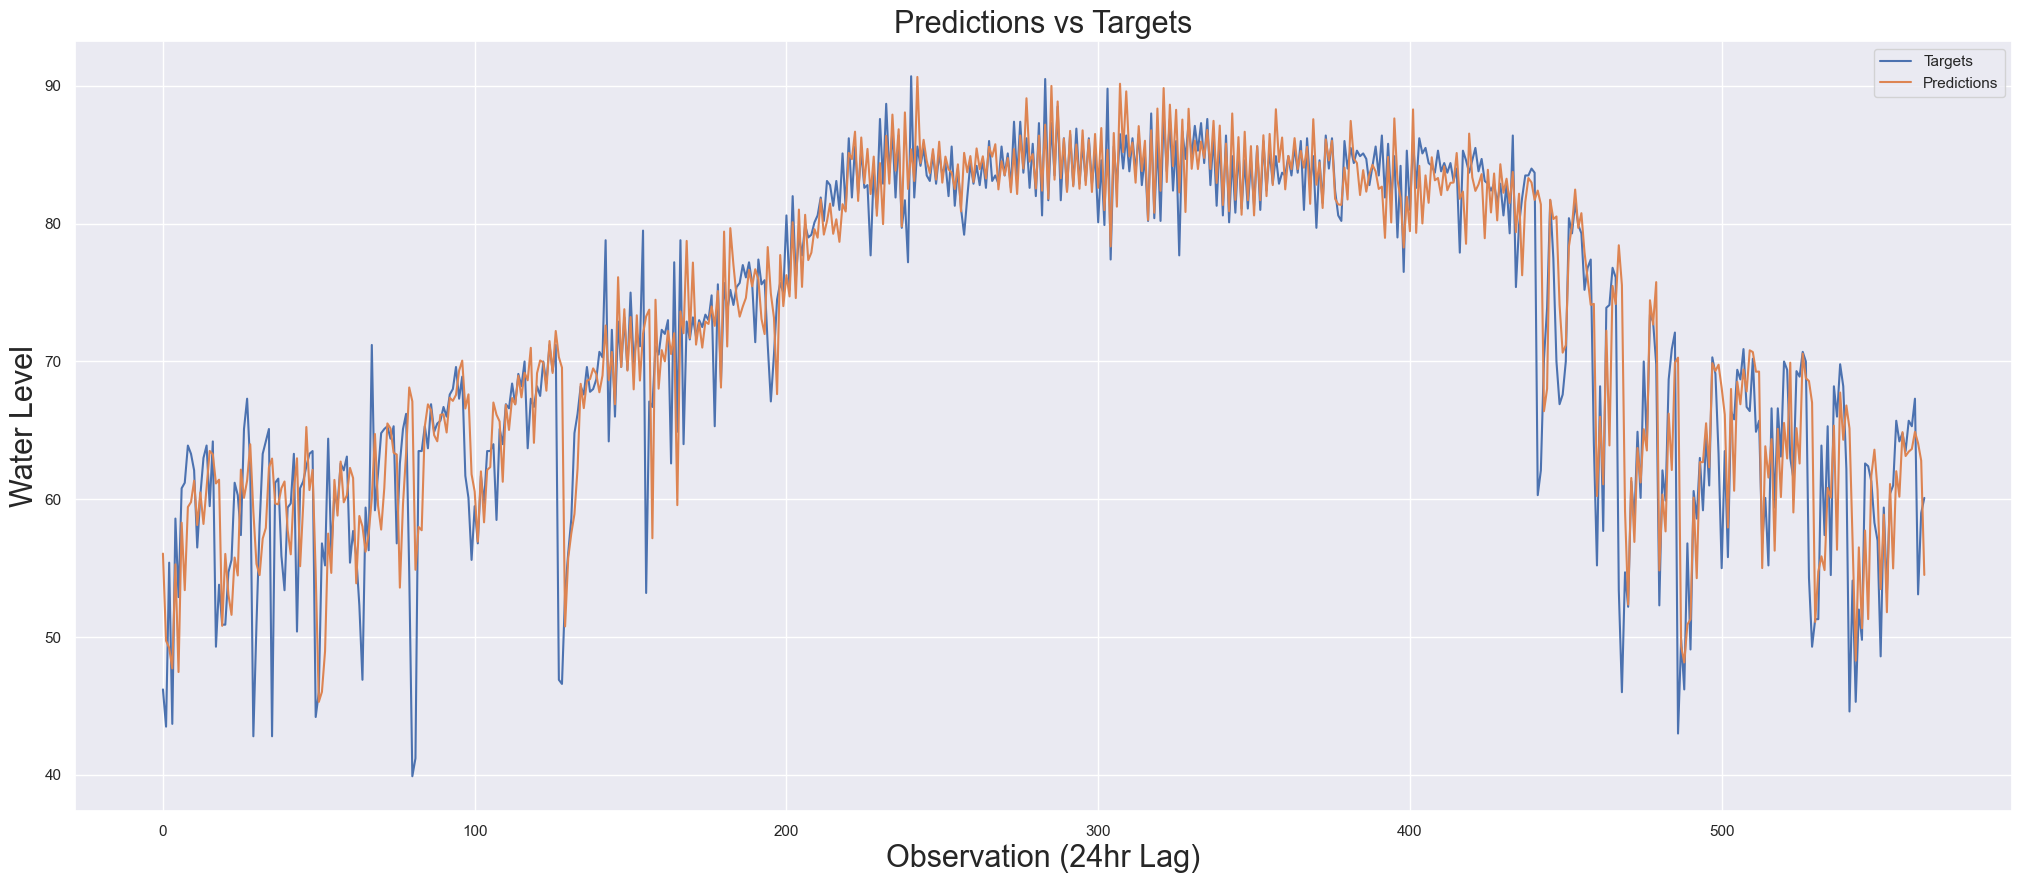

In [207]:
model_plot(predictions, validation_labels)

In [208]:
predictions = model.predict(testing_data)
evaluate_final(predictions, testing_labels)


Central Frequency: 0.8733205374280231
Mean Squared Error: 12.649680748412043
Root Mean Squared Error: 3.556638967960066
Average Error: 0.13680017810126363
Mean Absolute Error: 2.353440514164448
Median Absolute Error: 1.4228992392201434
Mean Error: 0.13680017810126363
R-squared: 0.839409056197262


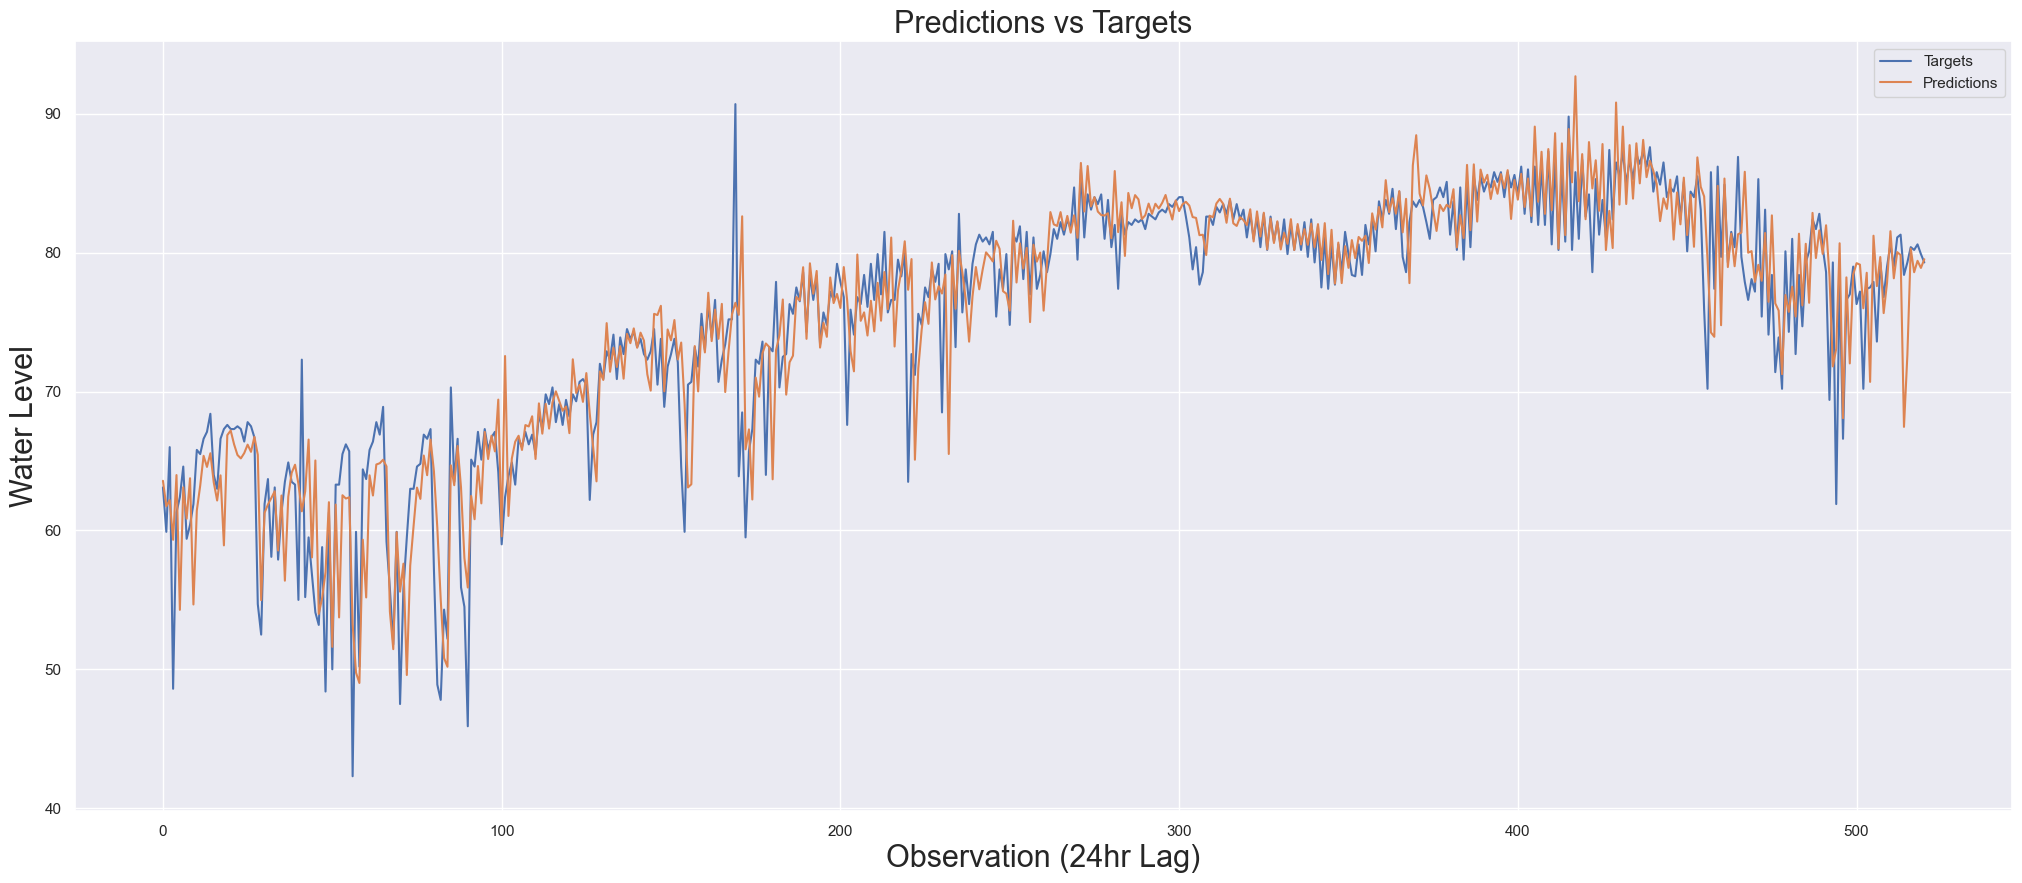

In [209]:
model_plot(predictions, testing_labels)